<a href="https://colab.research.google.com/github/skywalker0803r/deep-learning-ian-goodfellow/blob/master/offline%20DDPG%20general%20form.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset,DataLoader

# config
data_size = 10000 
batch_size = 256 
hidden_size = 128
state_size = 2 #['溫度,濕度']
request_size = 1 #['需求產出']
value_size = 1 #['實際產出']
action_size = 10 #['感測器數量']
time_step = 6 #['時間窗格']

In [2]:
# data
data = {}
data['state'] = torch.rand(data_size,state_size)
data['request'] = torch.rand(data_size,request_size)
data['action'] = torch.rand(data_size,time_step,action_size)
data['value'] = torch.rand(data_size,value_size)
data = TensorDataset(data['state'],data['request'],data['action'],data['value'])
train_iter = DataLoader(data,batch_size,shuffle=True)

In [3]:
class R2D2(nn.Module):
  def __init__(self,obs_size,n_actions,hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.l1 = nn.Linear(obs_size,self.hidden_size)
    self.l2 = nn.LSTMCell(self.hidden_size,self.hidden_size)
    self.l3 = nn.Linear(self.hidden_size,n_actions)
  
  def forward(self,x,hx,cx):
    x = torch.tanh(self.l1(x))
    hx,cx = self.l2(x,(hx,cx))
    x = torch.tanh(hx)
    x = torch.tanh(self.l3(x))
    return x,hx,cx

In [4]:
class ActorCritic(nn.Module):
  def __init__(self,actor,critic,time_step):
    super().__init__()
    self.time_step = time_step
    self.actor = actor
    self.critic = critic
    self.actor_optimizer = Adam(actor.parameters())
    self.critic_optimizer = Adam(critic.parameters())
  
  def forward():
    raise NotImplementedError
  
  def train_critic(self,state,action,value):
    '''
    x: [state,action]
    y: [value]
    '監督式學習'
    '''

    # initialize
    self.critic.train()
    hx = torch.zeros((state.size()[0],critic.hidden_size))
    cx = torch.zeros((state.size()[0],critic.hidden_size))
    
    # forward 
    for i in range(self.time_step):
      output,hx,cx = critic(torch.cat((state,action[:,i,:]),dim=1),hx,cx)
    
    # compute loss
    loss = ((output-value)**2).mean()
    
    # backward
    loss.backward()
    self.critic_optimizer.step()
    self.critic_optimizer.zero_grad()

    return loss.item()
  
  def train_actor(self,state,request):
    '''
    x: [state,request]
    y: maximum critic value
    '最大化產出'
    '''
    # initialize
    self.actor.train()
    self.critic.eval() 
    hx = torch.zeros((state.size()[0],actor.hidden_size))
    cx = torch.zeros((state.size()[0],actor.hidden_size))
    x = torch.cat((state,request),dim=1)
    actions = torch.FloatTensor()
    
    # forward actor 
    for i in range(self.time_step):
      output,hx,cx = actor(x,hx,cx)
      actions = torch.cat((actions,output),dim=1)
    actions = actions.reshape(state.size()[0],self.time_step,-1)

    # forward critic
    hx = torch.zeros((state.size()[0],critic.hidden_size))
    cx = torch.zeros((state.size()[0],critic.hidden_size))
    for i in range(self.time_step):
      output,hx,cx = critic(torch.cat((state,actions[:,i,:]),dim=1),hx,cx)
    
    # compute loss 最大化產出
    loss = -output.mean()
    
    # backward
    loss.backward()
    self.actor_optimizer.step()
    self.actor.zero_grad()

    return loss.item()

In [5]:
actor = R2D2(state_size+request_size,action_size,hidden_size)
critic = R2D2(state_size+action_size,value_size,hidden_size)
model = ActorCritic(actor,critic,time_step)

# train loop

In [6]:
def train_critic():
  loss = 0
  for i,(bs,br,ba,bv) in enumerate(train_iter):
    loss += model.train_critic(bs,ba,bv)
  return loss

def train_actor():
  loss = 0
  for i,(bs,br,ba,bv) in enumerate(train_iter):
    loss += model.train_actor(bs,br)
  return loss

In [7]:
def train(model,train_iter,epochs=100):
  train_history = {}
  train_history['actor'] = []
  train_history['critic'] = []
  
  for epoch in range(epochs):
    loss = train_critic()
    train_history['critic'].append(loss)
    print('epoch:{} critic_loss:{}'.format(epoch,loss))
    
  for epoch in range(epochs):
    loss = train_actor()
    train_history['actor'].append(loss)
    print('epoch:{} actor_loss:{}'.format(epoch,loss))
    
  return model,train_history

In [8]:
model,train_history = train(model,train_iter,epochs=100)

epoch:0 critic_loss:3.9076488316059113
epoch:1 critic_loss:3.377780094742775
epoch:2 critic_loss:3.3816442862153053
epoch:3 critic_loss:3.363008014857769
epoch:4 critic_loss:3.3408407419919968
epoch:5 critic_loss:3.3425231501460075
epoch:6 critic_loss:3.371134966611862
epoch:7 critic_loss:3.3517239317297935
epoch:8 critic_loss:3.33962619304657
epoch:9 critic_loss:3.3540580347180367
epoch:10 critic_loss:3.3382977917790413
epoch:11 critic_loss:3.353832930326462
epoch:12 critic_loss:3.349624417722225
epoch:13 critic_loss:3.341405026614666
epoch:14 critic_loss:3.3447036519646645
epoch:15 critic_loss:3.3491202294826508
epoch:16 critic_loss:3.376708433032036
epoch:17 critic_loss:3.3095729425549507
epoch:18 critic_loss:3.34204413741827
epoch:19 critic_loss:3.3302014991641045
epoch:20 critic_loss:3.334304131567478
epoch:21 critic_loss:3.382670648396015
epoch:22 critic_loss:3.326896585524082
epoch:23 critic_loss:3.3349062725901604
epoch:24 critic_loss:3.3570847138762474
epoch:25 critic_loss:3.3

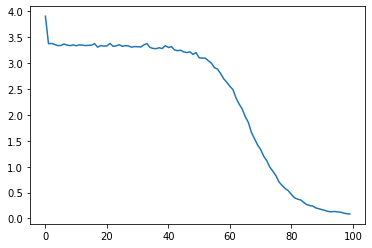

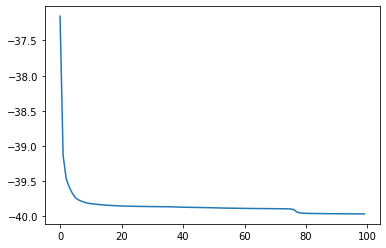

In [9]:
import matplotlib.pyplot as plt

plt.plot(train_history['critic'])
plt.show()
plt.plot(train_history['actor'])